# What are the most demanded skills for the top 3 popular data roles?

## Loading and Cleaning Dataset

In [1]:
#  Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

#  Using 'datasets' library to load dataset from hugging face (https://huggingface.co/datasets/lukebarousse/data_jobs)
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

#  Data Cleanup
#  Converting str to datetime
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
#  Converting str to list
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

## Filter for US Roles

In [2]:
df_US = df[df['job_country'] == 'United States']

## Explode Skills Column

In [3]:
df_skills = df_US.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
0,Senior Clinical Data Engineer / Principal Clin...,None
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,python
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,c++
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,java
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,matlab
...,...,...
785692,Data Scientist- Hybrid Work Location,r
785703,Data Analyst - CRYPTOGRAPHY - Full-time,None
785705,Expert Business Data Analyst - Now Hiring,sql
785705,Expert Business Data Analyst - Now Hiring,python


## Count Skills by Job Title

In [4]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1209,python,Data Scientist,42379
1521,sql,Data Analyst,34452
1523,sql,Data Scientist,30034
455,excel,Data Analyst,27519
1243,r,Data Scientist,26022
...,...,...,...
245,clojure,Software Engineer,1
1738,vb.net,Senior Data Scientist,1
530,fortran,Machine Learning Engineer,1
1116,planner,Cloud Engineer,1


## Create a List of Top 3 Roles

In [5]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

## Plot Skill Counts

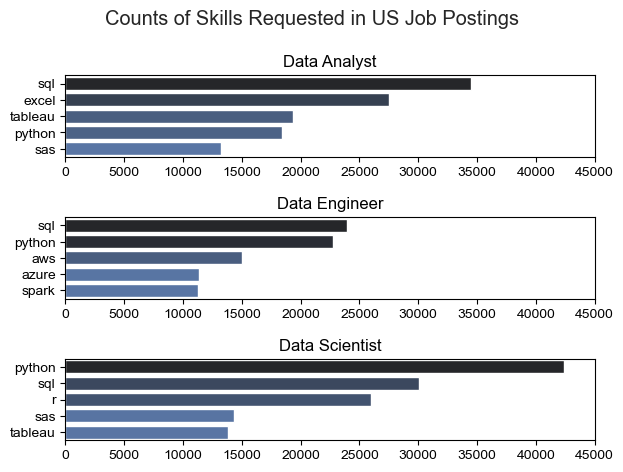

In [6]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 45000) # make the scales the same

fig.suptitle('Counts of Skills Requested in US Job Postings')
fig.tight_layout() # fix the overlap
plt.show()

## Convert Counts to Percentages

### Counts don't show what portions of jobs are requesting these skills

In [7]:
# Use original df to get the count of job titles
df_job_title_count = df_US['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Analyst,67816
1,Data Scientist,58830
2,Data Engineer,35080
3,Senior Data Scientist,12946
4,Senior Data Analyst,11791
5,Senior Data Engineer,9289
6,Business Analyst,7382
7,Software Engineer,1814
8,Machine Learning Engineer,921
9,Cloud Engineer,423


In [8]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,python,Data Scientist,42379,58830,72.036376
1,sql,Data Analyst,34452,67816,50.802171
2,sql,Data Scientist,30034,58830,51.052184
3,excel,Data Analyst,27519,67816,40.578919
4,r,Data Scientist,26022,58830,44.232534
...,...,...,...,...,...
1865,clojure,Software Engineer,1,1814,0.055127
1866,vb.net,Senior Data Scientist,1,12946,0.007724
1867,fortran,Machine Learning Engineer,1,921,0.108578
1868,planner,Cloud Engineer,1,423,0.236407


## Plot Percentage Count

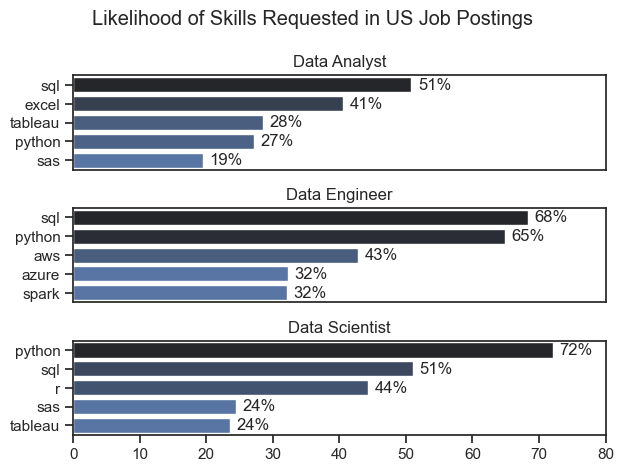

In [9]:
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 80)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in US Job Postings')
fig.tight_layout()
plt.show()